In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller

In [2]:
df=pd.read_csv('product j.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [3]:
sales_j= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_j.shape

(60, 1)

In [5]:
sales_j.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


In [6]:
sales_j['Sales'].sum()

4532957

Text(0.5, 1.0, 'Product J')

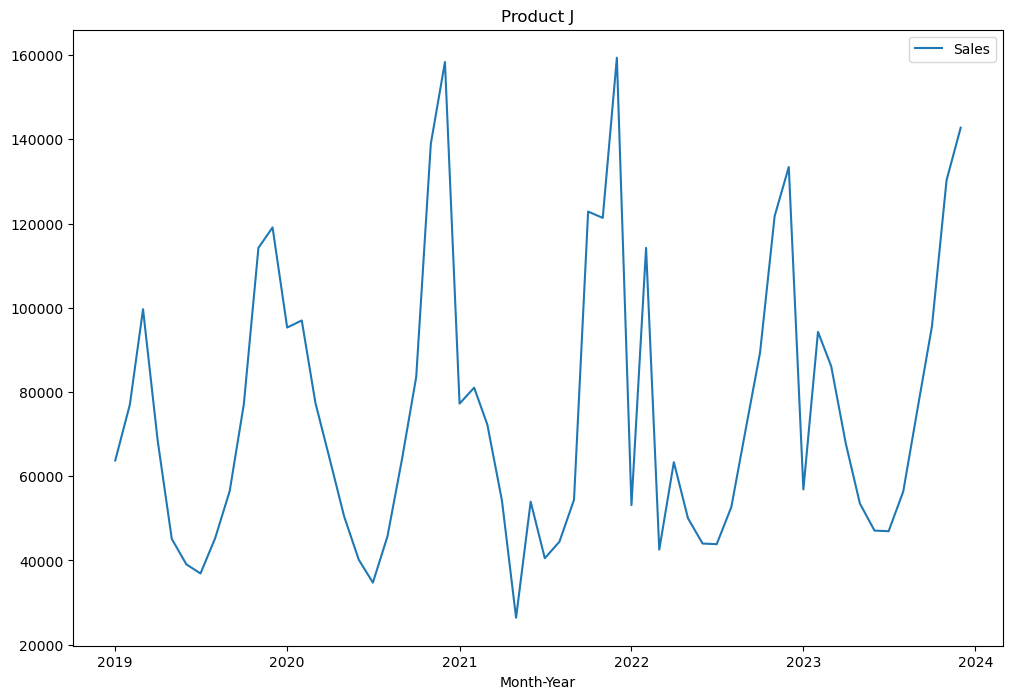

In [7]:
plt.figure(figsize=(12,8))
sns.lineplot(sales_j)
plt.title('Product J')

In [8]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [9]:
adf_test(sales_j)

ADF Statistics: -2.3759301997991913
p- value: 0.14864548261740318
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [10]:
sales_j_diff= sales_j.diff().dropna()

Text(0.5, 1.0, 'Product J- First Difference')

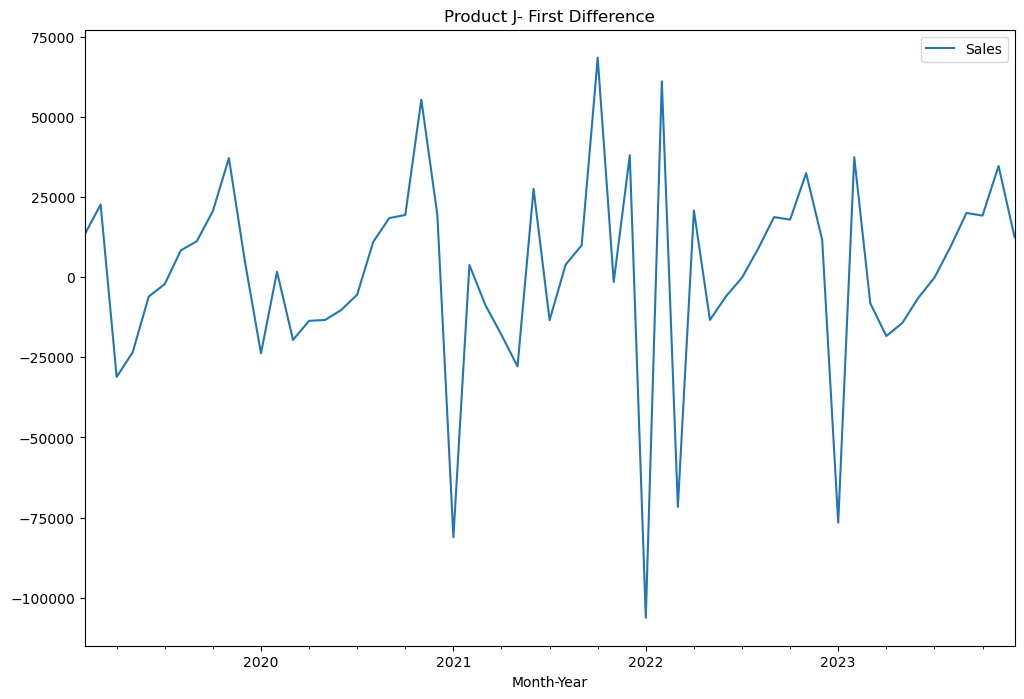

In [11]:
sales_j_diff.plot(figsize=(12,8))
plt.title('Product J- First Difference')

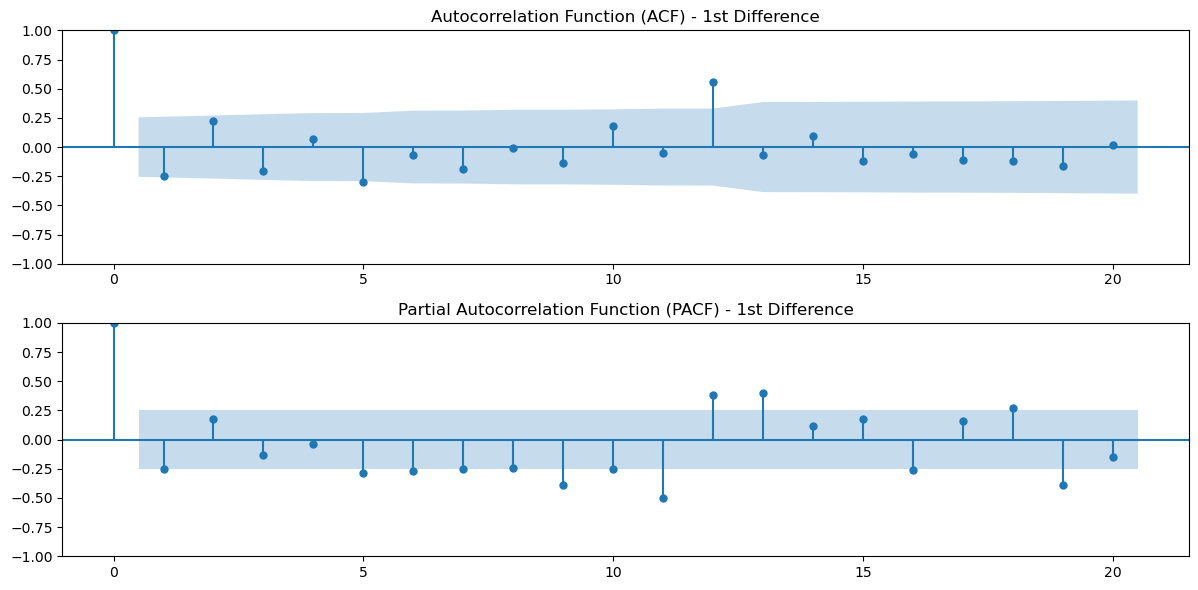

In [12]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_j_diff, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - 1st Difference')

plt.subplot(212)
plot_pacf(sales_j_diff, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - 1st Difference')

plt.tight_layout()
plt.show()

In [13]:
adf_test(sales_j_diff)

ADF Statistics: -6.410493361286657
p- value: 1.896152982571653e-08
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [14]:
train= sales_j[:54]
test=sales_j[54:]

In [15]:
len(train)

54

In [16]:
#the combination p=(0,1,2,3,4,5) d=1 q=(0,1,2,3) must be tested with accuracy metrics and aic

In [17]:
#param = [(0,1,0),(0,1,1),(0,1,2),(0,1,3),(1,1,0),(1,1,1),(1,1,2),(1,1,3),(2,1,0), (2,1,1), (2, 1, 2),(2,1,3),(3,1,0),(3,1,1),(3,1,2),(3,1,3),(4,1,0),(4,1,1),(4,1,2),(4,1,3),(5,1,0),(5,1,1),(5,1,2),(5,1,3)]

#for p in param:  # Changed 'x' to 'p'
#    model = ARIMA(train, order=p).fit()
#    pred = model.forecast(steps=len(test))
#    mae = mean_absolute_error(test, pred)
#    # Calculate MAPE manually
#    mape = np.mean(np.abs((test - pred) / test)) * 100
#    mse=mean_squared_error(test, pred)
#    rmse = np.sqrt(mean_squared_error(test, pred))
#    print(p)
#    print(f'MAE: {mae}')
#    print(f'MSE: {mse}')
#    print(f'RMSE: {rmse}')
#    print('A.I.C:', model.aic)

In [18]:
order=[]
for p in range(6):
    # Loop over MA order
    for q in range(3):
        # Fit model        
#       model= ARIMA(sales_i, order=(p,1,q))
        model_t = ARIMA(train['Sales'], order=(p,1,q))
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_j)-1))
        mae = mean_absolute_error(test, pred)
        mape = np.mean(np.abs((test - pred) / test)) * 100
        mse=mean_squared_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [19]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q          aic          bic           mae           mse          rmse
11  3  2  1240.647416  1252.469168  18607.017477  6.751872e+08  25984.363682
17  5  2  1241.893639  1257.655974  16372.841047  5.142389e+08  22676.836163
16  5  1  1244.371582  1258.163625  21001.392931  8.467747e+08  29099.393347
10  3  1  1244.645697  1254.497157  26077.240033  1.266401e+09  35586.523167
13  4  1  1246.188411  1258.010163  23953.515223  1.099081e+09  33152.394949
14  4  2  1247.336500  1261.128544  26263.198014  1.279697e+09  35772.858339
8   2  2  1248.045018  1257.896477  31873.017425  1.778616e+09  42173.640049
4   1  1  1250.747302  1256.658178  46681.395319  3.425984e+09  58531.907529
3   1  0  1251.618028  1255.558612  43565.874339  3.117771e+09  55837.006574
6   2  0  1252.109996  1258.020872  46088.139246  3.407134e+09  58370.656433
1   0  1  1252.505324  1256.445908  42977.523264  3.050479e+09  55231.139207
7   2  1  1252.657564  1260.538731  46558.157767  3.409443e+09  58390.432668

In [20]:
m_arima= ARIMA (train, order=(3,1,2))
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   54
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -614.324
Date:                Thu, 09 May 2024   AIC                           1240.647
Time:                        19:03:20   BIC                           1252.469
Sample:                    01-01-2019   HQIC                          1245.193
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1388      0.195      5.851      0.000       0.757       1.520
ar.L2         -0.1059      0.288     -0.367      0.713      -0.671       0.459
ar.L3         -0.4134      0.192     -2.158      0.0

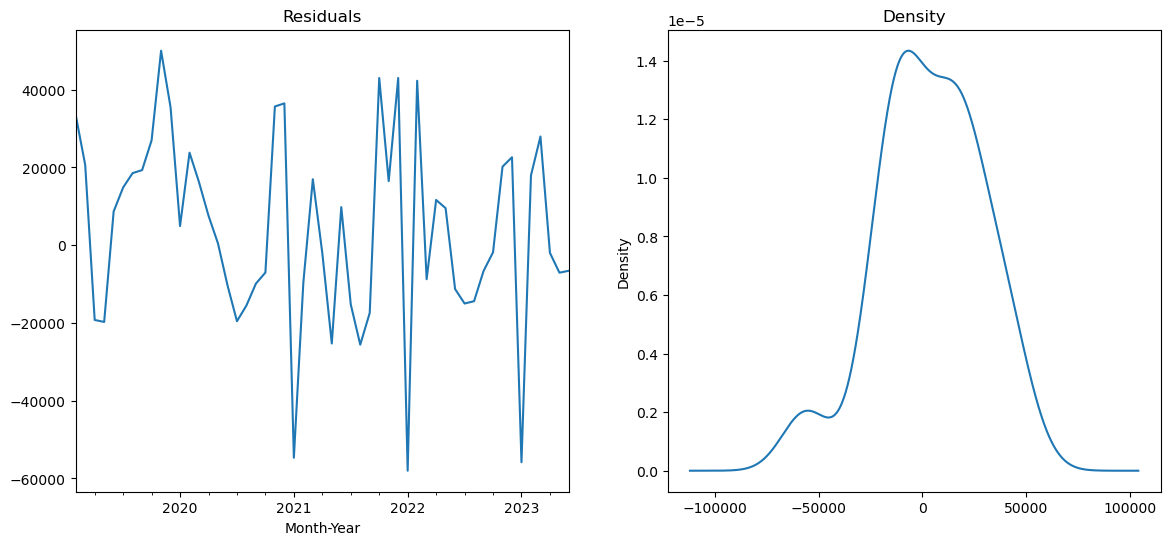

In [21]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

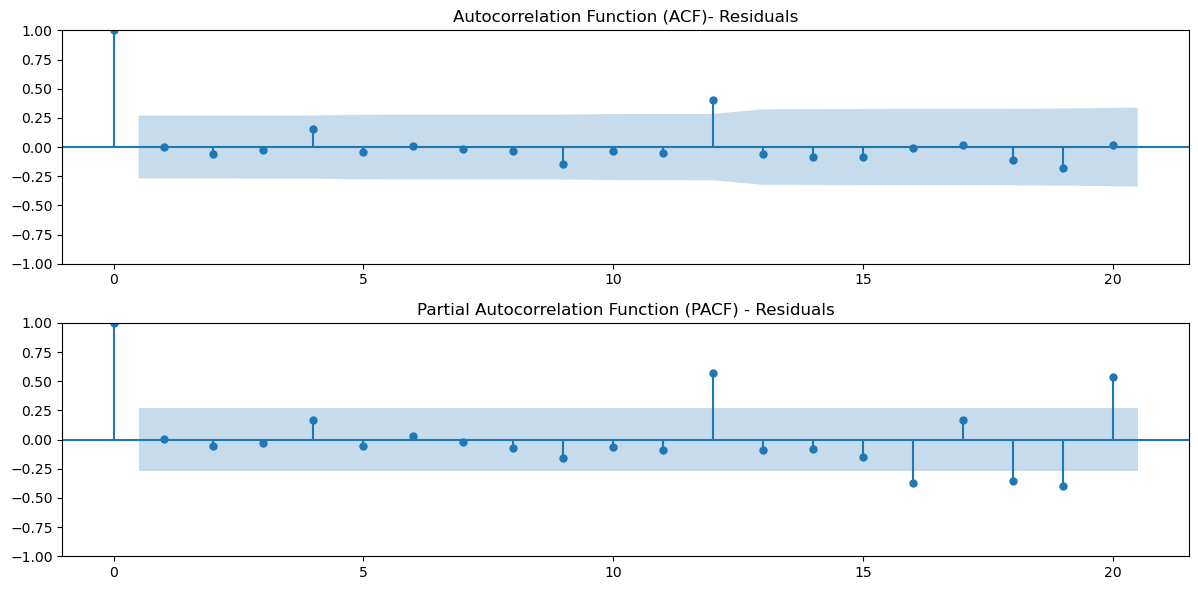

In [22]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

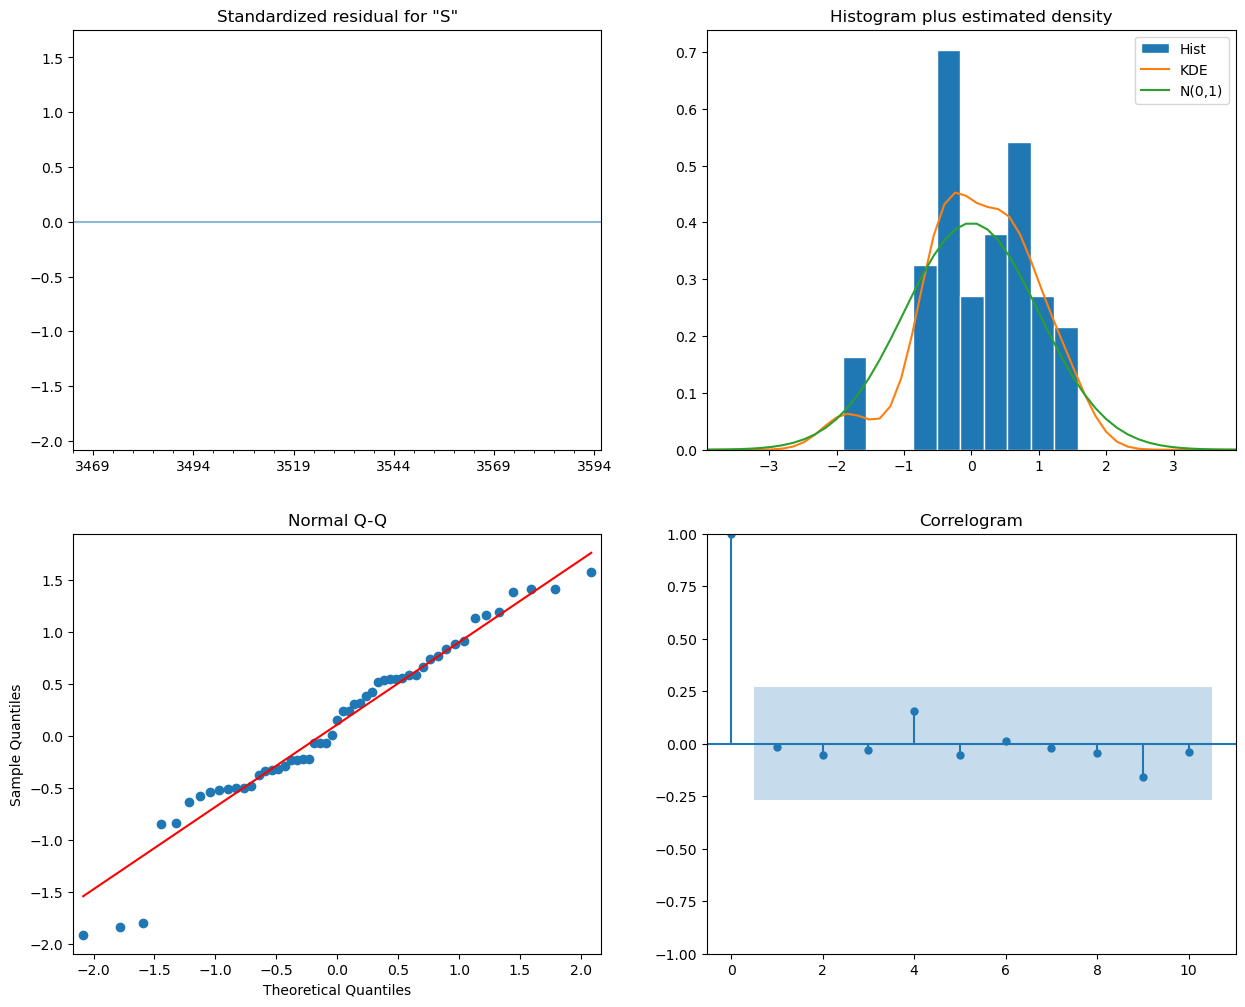

In [23]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [24]:
#pred=model.forecast(steps= len(test))
#sales_j['Forecast_ARIMA']=[None]*len(train) + list(pred)
#sales_j.plot()

In [25]:
pred=model_arima.predict(start=len(train), end=(len(sales_j)-1), dynamic = True)
sales_j['Forecast_ARIMA']=[None]*len(train) + list(pred)

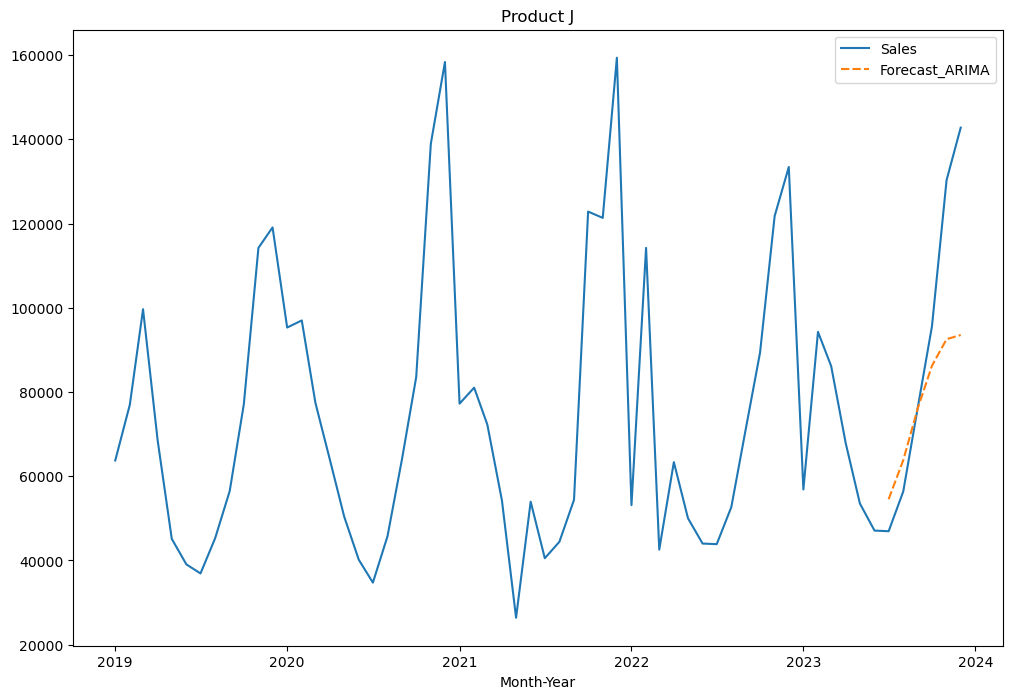

In [26]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_j)
plt.title('Product J')
plt.show()

In [27]:
mae_arima= mean_absolute_error(test,pred)
mse_arima=mean_squared_error(test, pred)
mape_arima= mean_absolute_percentage_error(test,pred)
rmse_arima= np.sqrt(mean_squared_error(test,pred))

print(f'MAE - ARIMA: {mae_arima}')
print(f'MAPE - ARIMA: {mape_arima}')
print(f'MSE - ARIMA: {mse_arima}')
print(f'RMSE - ARIMA: {rmse_arima}')

MAE - ARIMA: 18607.017476586287
MAPE - ARIMA: 0.17164127581474217
MSE - ARIMA: 675187155.9667808
RMSE - ARIMA: 25984.363682160485


# SARIMA

In [28]:
import statsmodels.api as sm

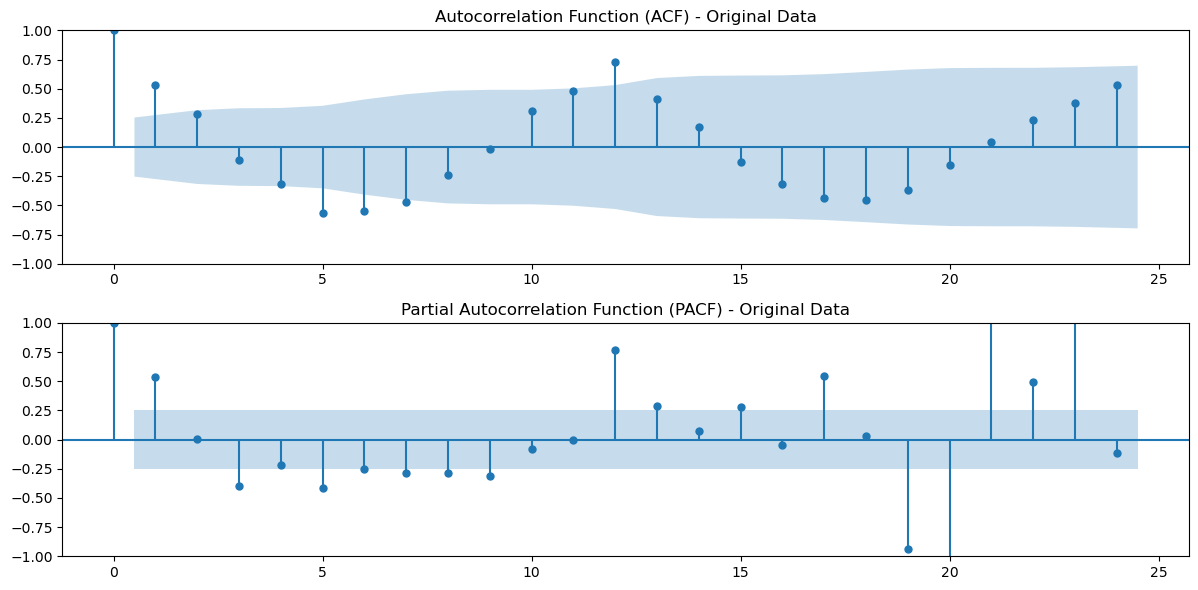

In [29]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_j['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_j['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

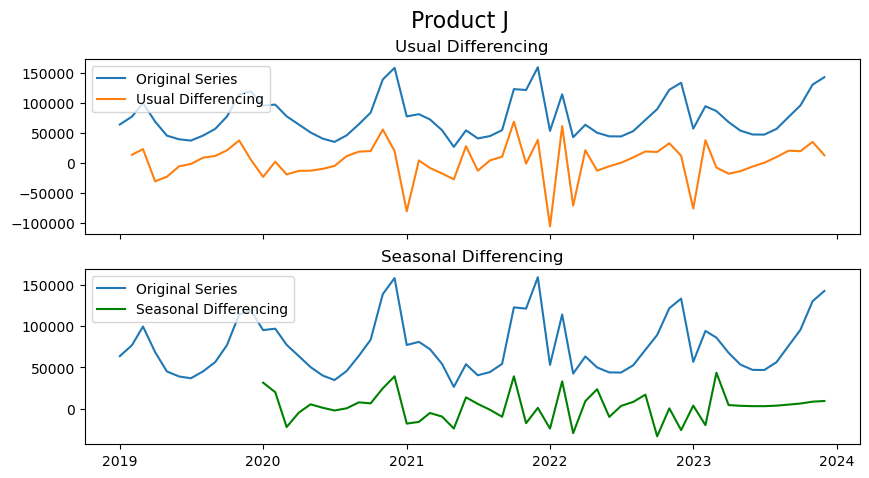

In [30]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(sales_j['Sales'], label='Original Series')
axes[0].plot(sales_j['Sales'].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(sales_j['Sales'], label='Original Series')
axes[1].plot(sales_j['Sales'].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Product J', fontsize=16)
plt.show()

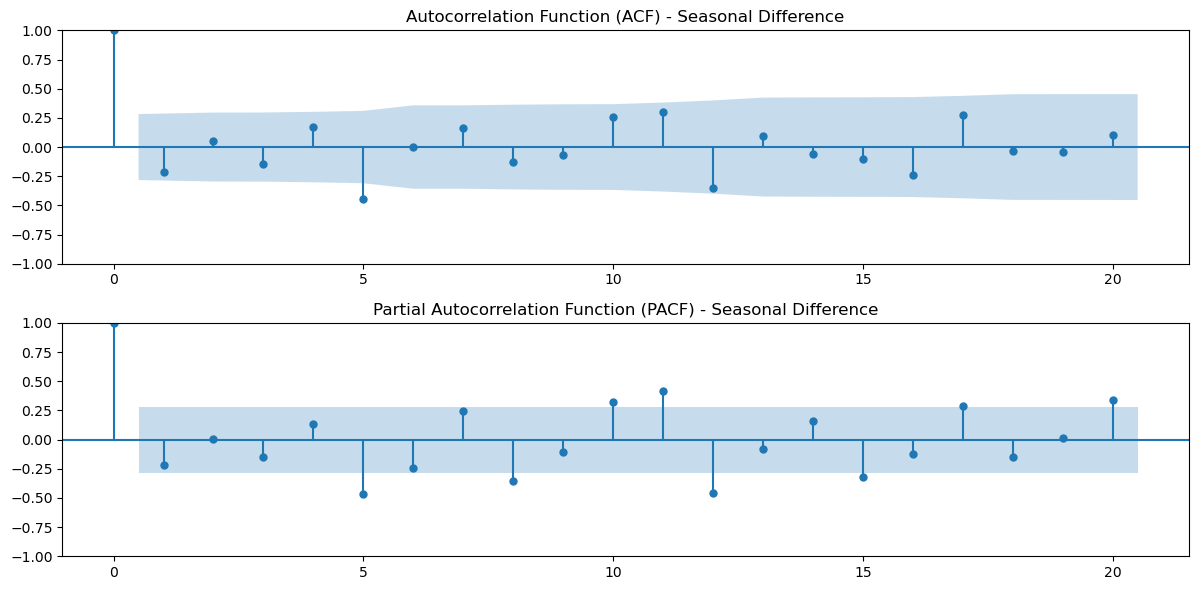

In [31]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_j['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Seasonal Difference')

plt.subplot(212)
plot_pacf(sales_j['Sales'].diff(12).dropna(), lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Seasonal Difference')

plt.tight_layout()
plt.show()

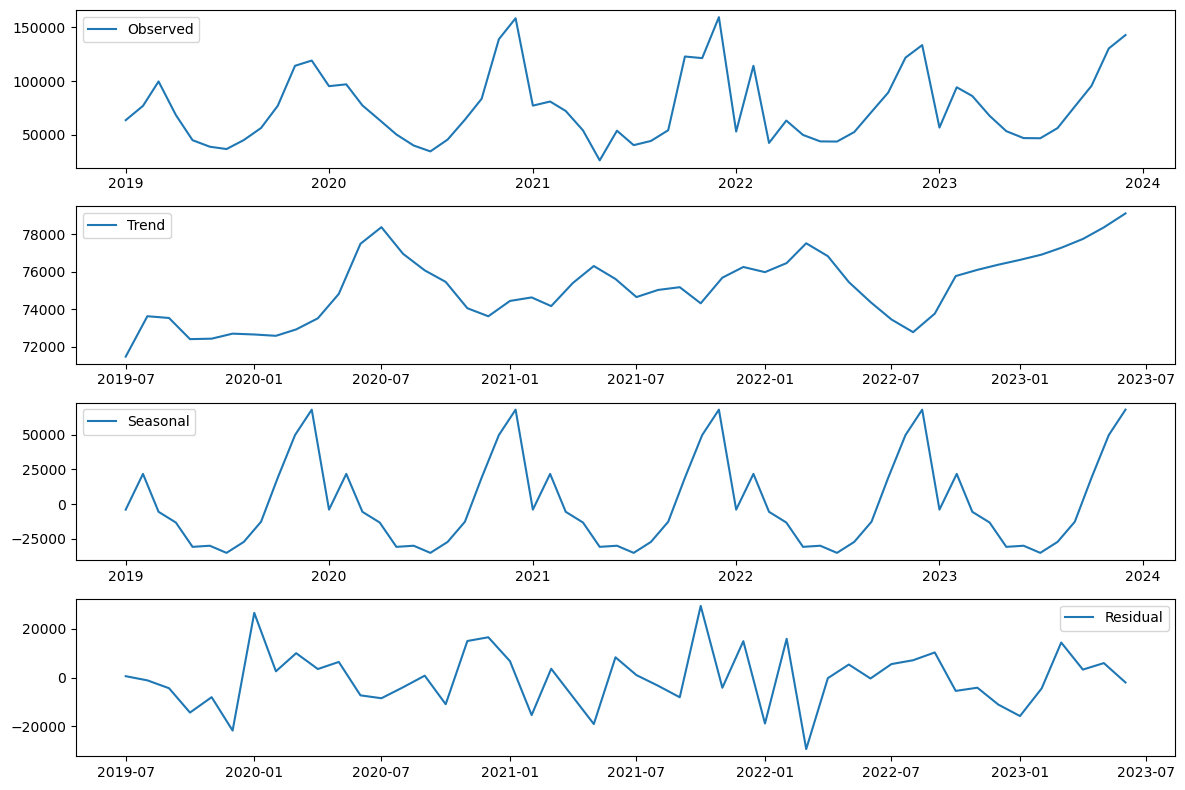

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_j['Sales'], model='additive', period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [33]:
order_SARIMAX=[]
# Loop over P order
for P in range(6):
    # Loop over Q order
    for Q in range(2):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(3, 1, 2), seasonal_order=(P, 1, Q, 12))
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=54, end=59, dynamic=True)
        mae = mean_absolute_error(test, pred)
        mse = mean_squared_error(test, pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic, mae, mse))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic', 'mae', 'mse'])

In [34]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

    P  Q         aic         bic           mae           mse
6   3  0  950.248824  965.670972   9537.145817  1.423166e+08
0   0  0  951.255726  961.537159   5468.115335  4.177414e+07
1   0  1  951.777151  963.772155   4443.983815  3.145587e+07
8   4  0  952.001206  969.136926  15321.487193  3.451071e+08
7   3  1  952.053132  969.188852  14014.604717  2.876474e+08
5   2  1  952.618809  968.040958   8587.445130  1.050504e+08
2   1  0  953.115178  965.110182   5372.314698  3.700375e+07
3   1  1  953.496674  967.205250   7027.536595  7.009902e+07
4   2  0  953.979855  967.688431   4437.106080  3.020496e+07
10  5  0  953.980855  972.830147  15269.630573  3.451158e+08
9   4  1  954.003167  972.852460  15284.428436  3.433021e+08
11  5  1  955.978417  976.541282  15229.626183  3.433358e+08


In [35]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(3, 1, 2),seasonal_order=(3,1,0,12))
sarima_model=sarima.fit()

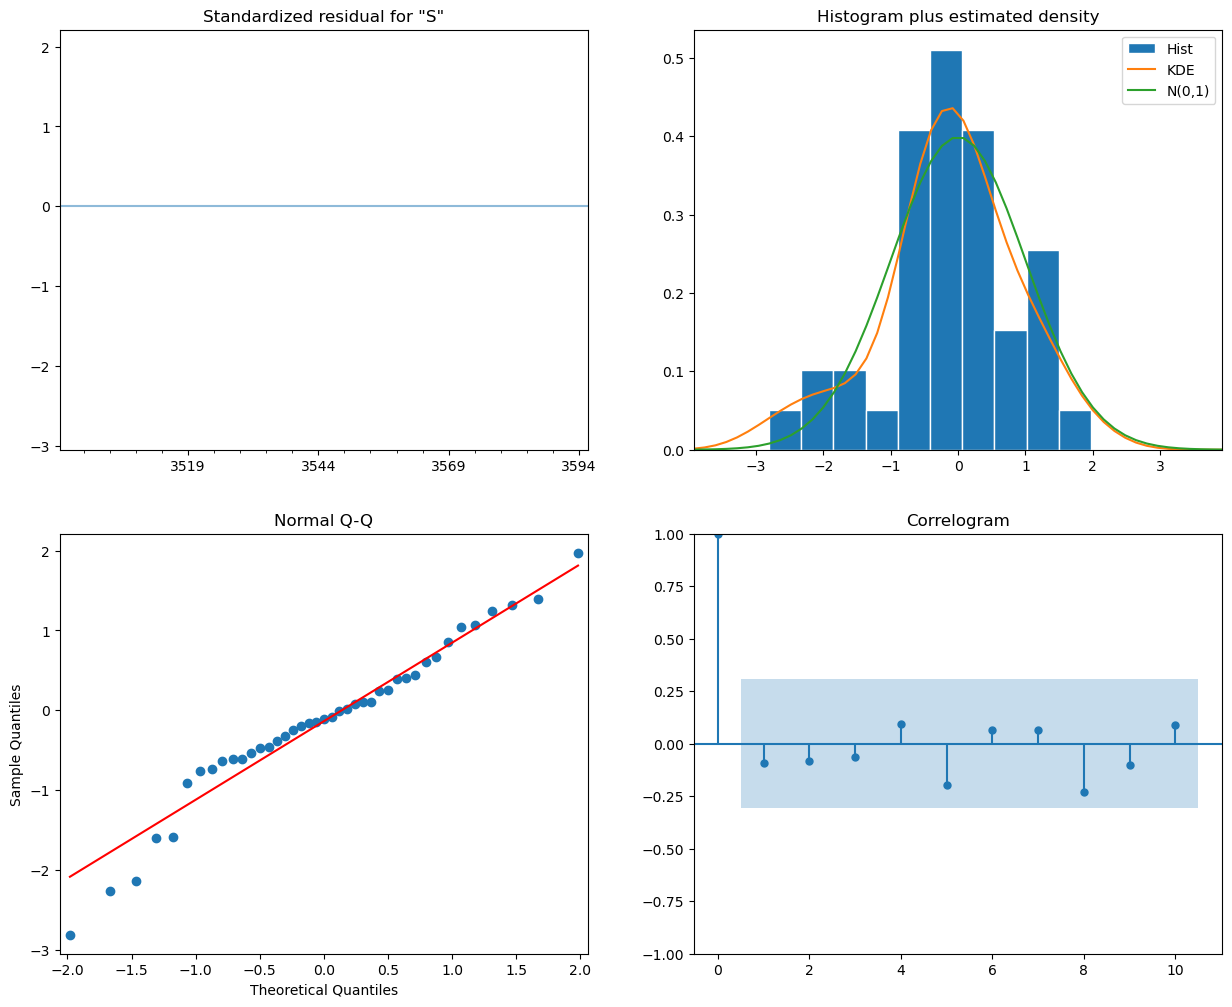

In [36]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [37]:
forecast_test_sarima=sarima_model.predict(start=54,end=59,dynamic=True)

In [38]:
sales_j['Forecast_SARIMA']=[None]*len(train)+ list(forecast_test_sarima)
#sales_b[['Sales','Forecast_SARIMA']].plot(figsize=(12,8))

Text(0.5, 1.0, 'Product J')

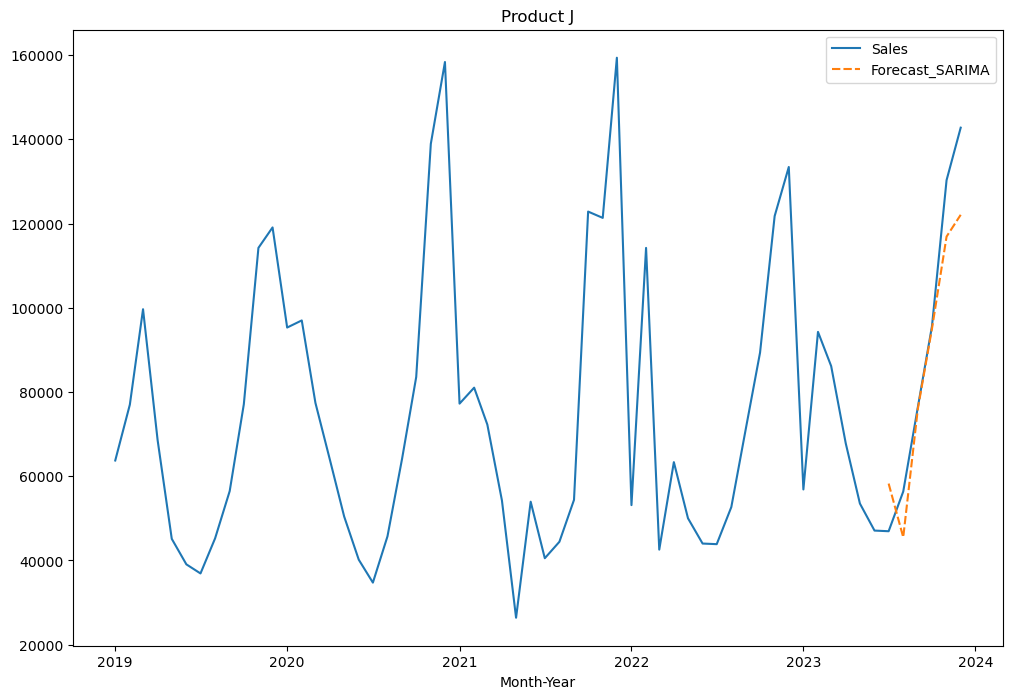

In [39]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_j[['Sales','Forecast_SARIMA']])
plt.title('Product J')

In [40]:
mae_sarima= mean_absolute_error(test,forecast_test_sarima)
mape_sarima= mean_absolute_percentage_error(test,forecast_test_sarima)
mse_sarima=mean_squared_error(test, forecast_test_sarima)
rmse_sarima= np.sqrt(mean_squared_error(test,forecast_test_sarima))

print(f'MAE - SARIMA: {round(mae_sarima,3)}')
print(f'MAPE - SARIMA: {round(mape_sarima,3)}')
print(f'MSE - SARIMA: {round(mse_sarima,3)}')
print(f'RMSE - SARIMA: {round(rmse_sarima,3)}')

MAE - SARIMA: 9537.146
MAPE - SARIMA: 0.115
MSE - SARIMA: 142316631.803
RMSE - SARIMA: 11929.653


# AUTO-ARIMA

In [41]:
import pmdarima as pm

In [42]:
auto_arima= pm.auto_arima(train, start_p=0, d=1, start_q=0, max_p=6,max_q=3,
                          start_P=0, D=1, start_Q=0, max_P=6 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=965.053, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=960.869, Time=0.31 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=962.775, Time=0.25 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=961.545, Time=0.10 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=1.09 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=964.284, Time=0.71 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=965.874, Time=0.39 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.98 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=965.141, Time=0.93 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=inf, Time=4.47 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=7.46 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=966.258, Time=3.19 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=964.685, Time=1.83 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=966.462, Time=4.31 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=966.685, Time=4.34 sec
 ARIMA(0,1,1)(0,1,0)[12]  

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [43]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   54
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -472.415
Date:                              Thu, 09 May 2024   AIC                            950.830
Time:                                      19:09:17   BIC                            955.971
Sample:                                  01-01-2019   HQIC                           952.702
                                       - 06-01-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4716      0.104     -4.514      0.000      -0.676      -0.267
ma.S.L12      -0.2656      0.089     -2.993      0.003      -0.440      -0.092
sigma2      5.665e+08   2.74e-11   2.07e+19      0.000    5.67e+08    5.67e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                 0.62
Prob(Q):                              0.59   Prob(JB):                         0.74
Heteroskedasticity (H):               0.41   Skew:                            -0.27
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.28e+34. Standard errors may be unstable.
"""

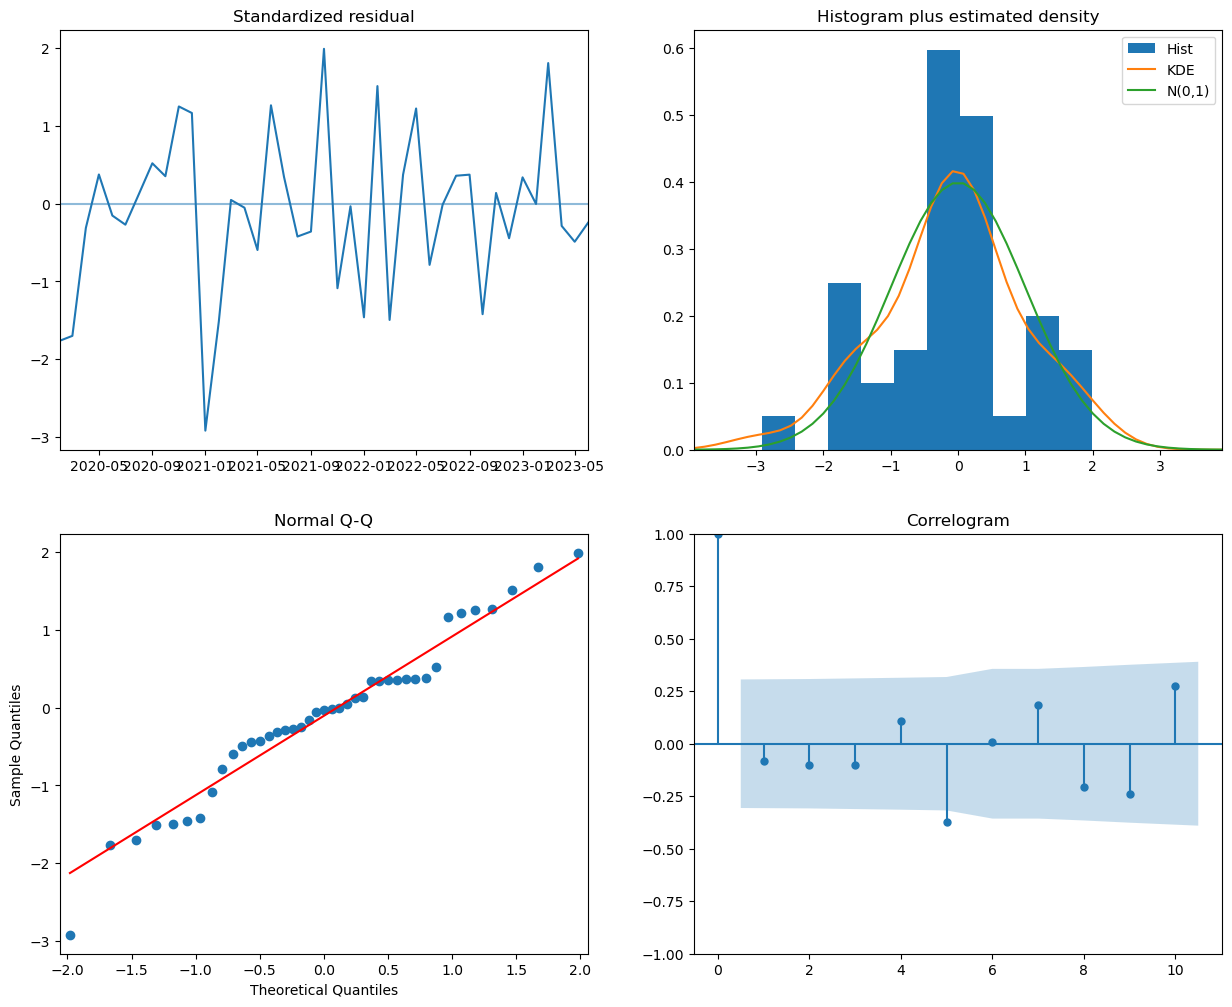

In [44]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [45]:
forecast_test_auto= auto_arima.predict(n_periods=len(test))
sales_j['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)
#sales_j.plot()

Text(0.5, 1.0, 'Product J')

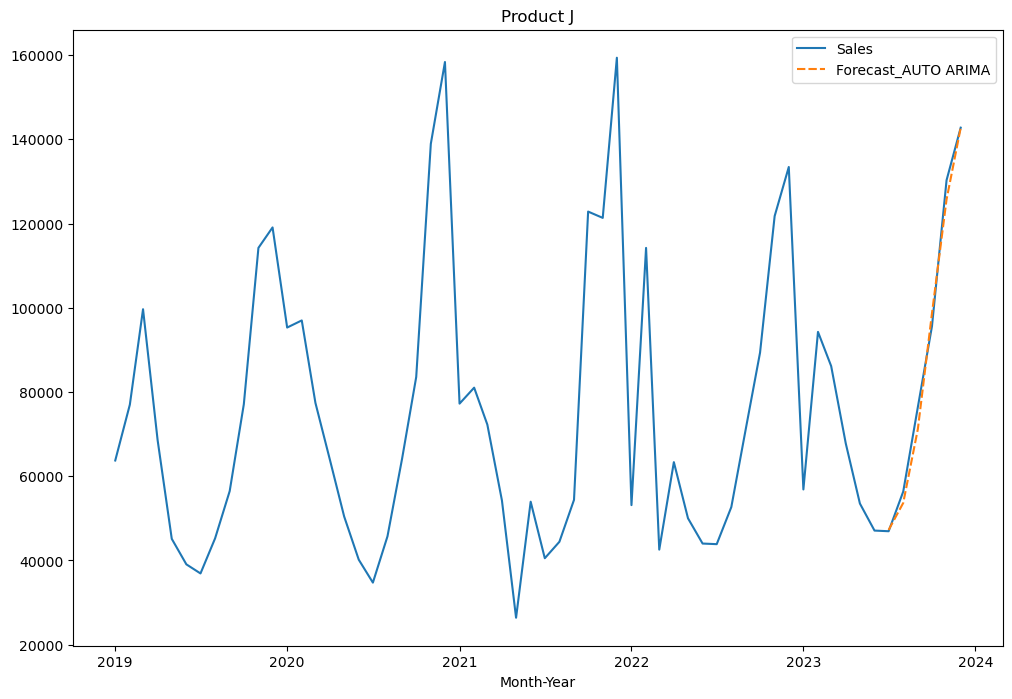

In [46]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_j[['Sales','Forecast_AUTO ARIMA']])
plt.title('Product J')

In [47]:
mae_auto_arima= mean_absolute_error(test,forecast_test_auto)
mape_auto_arima= mean_absolute_percentage_error(test,forecast_test_auto)
mse_auto_arima=mean_squared_error(test,forecast_test_auto)
rmse_auto_arima= np.sqrt(mean_squared_error(test,forecast_test_auto))

print(f'MAE - AUTO ARIMA: {mae_auto_arima}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima}')

MAE - AUTO ARIMA: 2649.1948063784766
MAPE - AUTO ARIMA: 0.0317098256819767
MSE - AUTO ARIMA: 10820042.924255539
RMSE - AUTO ARIMA: 3289.3833653521656


In [48]:
sales_j.tail(12)

,Sales,Forecast_ARIMA,Forecast_SARIMA,Forecast_AUTO ARIMA
Month-Year,,,,
2023-01-01,56843,NaN,NaN,NaN
2023-02-01,94268,NaN,NaN,NaN
2023-03-01,86135,NaN,NaN,NaN
2023-04-01,67767,NaN,NaN,NaN
2023-05-01,53500,NaN,NaN,NaN
2023-06-01,47080,NaN,NaN,NaN
2023-07-01,46924,54536.282223,58240.910932,47233.610342
2023-08-01,56348,63779.525807,45488.497914,53646.685413
2023-09-01,76393,76169.961554,76001.369613,71168.132621


In [49]:
sales_j.mean()

Sales                  75549.283333
Forecast_ARIMA         77792.918534
Forecast_SARIMA        85620.491161
Forecast_AUTO ARIMA    89863.557505
dtype: float64

In [50]:
data = {
    'model': ['ARIMA', 'AUTO ARIMA', 'SEASONAL ARIMA'],
    'MAE': [mae_arima, mae_auto_arima, mae_sarima],  
    'MAPE': [mape_arima, mape_auto_arima, mape_sarima],  
    'MSE': [mse_arima, mse_auto_arima, mse_sarima],  
    'RMSE': [rmse_arima, rmse_auto_arima, rmse_sarima]  
}

model_results = pd.DataFrame(data)
model_results.set_index('model', inplace=True)
model_results

,MAE,MAPE,MSE,RMSE
model,,,,
ARIMA,18607.017477,0.171641,6.751872e+08,25984.363682
AUTO ARIMA,2649.194806,0.031710,1.082004e+07,3289.383365
SEASONAL ARIMA,9537.145817,0.115455,1.423166e+08,11929.653465


# TESTING

In [18]:
auto_arima_1= pm.auto_arima(train, start_p=0, start_q=0, max_p=5,max_q=3,
                          start_P=0, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_1

 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=951.254, Time=0.03 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=952.941, Time=0.07 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=954.126, Time=0.26 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=952.993, Time=0.06 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=954.777, Time=0.19 sec
 ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=953.888, Time=0.22 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(2,1,2)[12] intercept   : AIC=954.693, Time=1.11 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=953.463, Time=0.07 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=954.978, Time=0.17 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=956.187, Time=0.38 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=955.056, Time=0.10 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=956.809, Time=0.33 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(0,0,1)(2,1,0)[1

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True)

In [19]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   54
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -473.627
Date:                  Wed, 08 May 2024   AIC                            951.254
Time:                          20:18:41   BIC                            954.729
Sample:                      01-01-2019   HQIC                           952.528
                           - 06-01-2023                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1809.8571   3037.037      0.596      0.551   -4142.626    7762.340
sigma2      3.651e+08   9.22e+07      3.960      0.000    1.84e+08    5.46e+08
===================================================================================
Ljung-Box (L1) (Q):                   2.22   Jarque-Bera (JB):                 0.94
Prob(Q):                              0.14   Prob(JB):                         0.63
Heteroskedasticity (H):               1.13   Skew:                             0.30
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
forecast_test_auto_1= auto_arima_1.predict(n_periods=len(test))
sales_j['Forecast_AUTO ARIMA_1']=[None]*len(train)+ list(forecast_test_auto_1)

Text(0.5, 1.0, 'Product J')

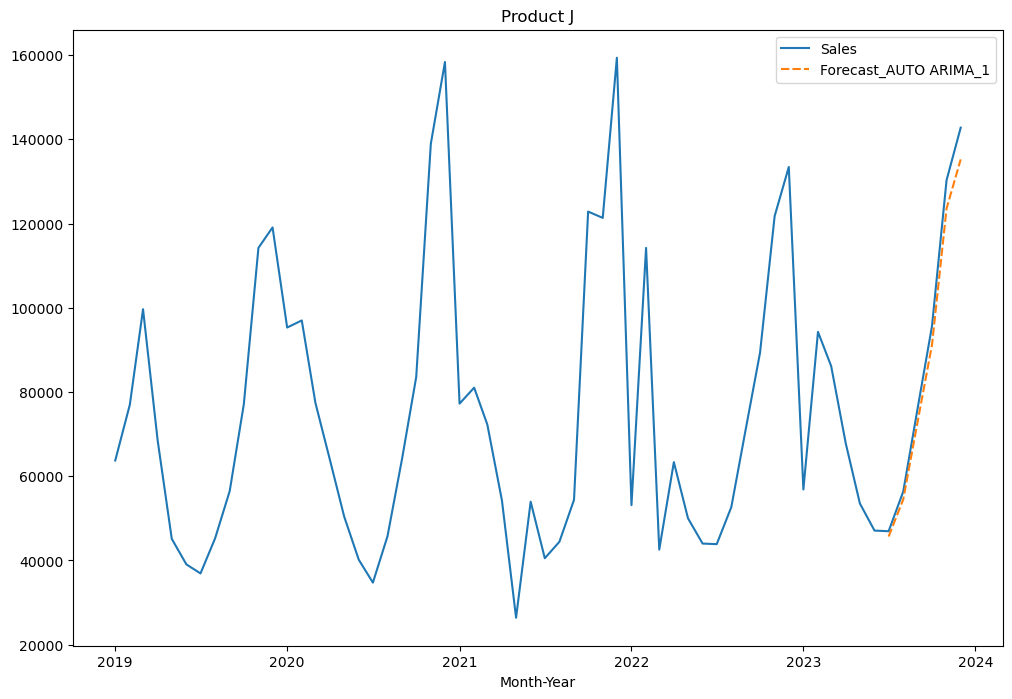

In [21]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_j[['Sales','Forecast_AUTO ARIMA_1']])
plt.title('Product J')

In [22]:
mae_auto_arima_1= mean_absolute_error(test,forecast_test_auto_1)
mape_auto_arima_1= mean_absolute_percentage_error(test,forecast_test_auto_1)
mse_auto_arima_1=mean_squared_error(test,forecast_test_auto_1)
rmse_auto_arima_1= np.sqrt(mean_squared_error(test,forecast_test_auto_1))

print(f'MAE - AUTO ARIMA: {mae_auto_arima_1}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima_1}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima_1}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima_1}')

MAE - AUTO ARIMA: 4168.476190476191
MAPE - AUTO ARIMA: 0.042105114896235966
MSE - AUTO ARIMA: 22797582.639455806
RMSE - AUTO ARIMA: 4774.681417587545
